# Drive mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/MIRA'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/MIRA


#Import Libraries

In [ ]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph

In [ ]:
import os, sys
import numpy as np
import nibabel as nib
import neurite as ne
import voxelmorph as vxm
from scipy.ndimage import zoom
import keras.layers

In [ ]:
#for interactive plots
%matplotlib notebook
#for static images
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
!pip install pydicom medpy
from medpy.io import load
#mage_data, image_header = load('/path/to/image.mha')
from scipy import ndimage
from skimage import measure
from scipy import stats
import nibabel as nib
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#DATA PREPARATION (todo only once)

In [ ]:
def segm(image_data):
  temp = np.zeros(image_data.shape)
  #threshold between 0 and 800
  temp[image_data > 0] = 1
  temp[image_data > 800] = 0
  struct1 = ndimage.generate_binary_structure(3, 1)
  struct2 = ndimage.iterate_structure(struct1, 2)
  temp = ndimage.binary_closing(temp, structure=struct1, iterations=1)
  temp = ndimage.binary_opening(temp, structure=struct2, iterations=1)
  temp = measure.label(temp)

  upperlim = temp[128:192, 256, 64:94]
  upperlim = stats.mode(upperlim[upperlim > 0])[0][0]
  lowerlim = temp[320:448, 256, 64:94]
  lowerlim = stats.mode(lowerlim[lowerlim > 0])[0][0]

  temp[temp == upperlim] = -1
  temp[temp == lowerlim] = -1
  temp[temp > 0] = 0
  return (temp*-1)

126
(512, 512)


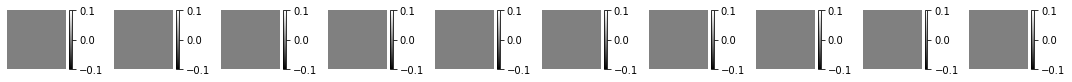

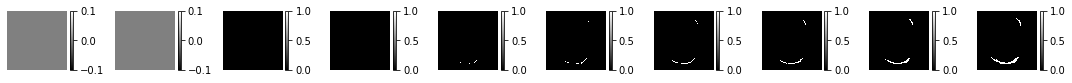

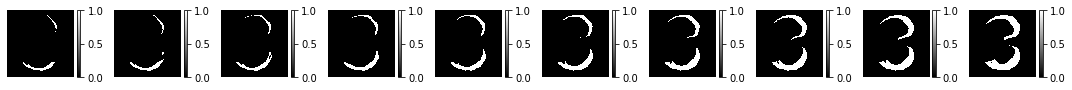

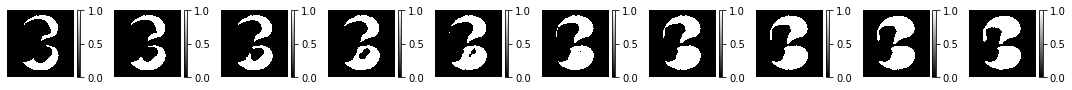

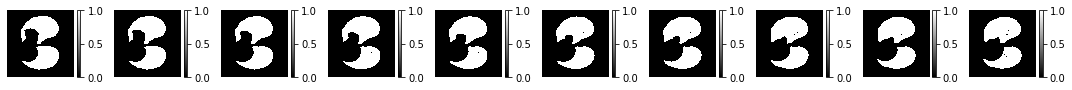

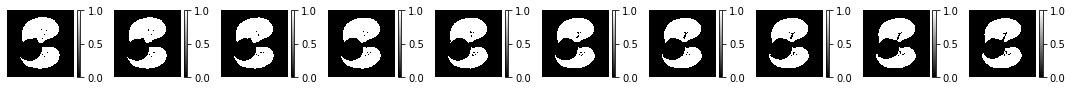

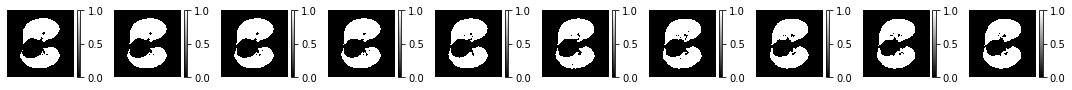

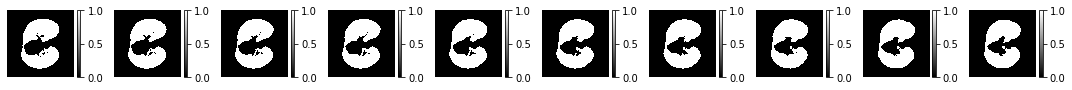

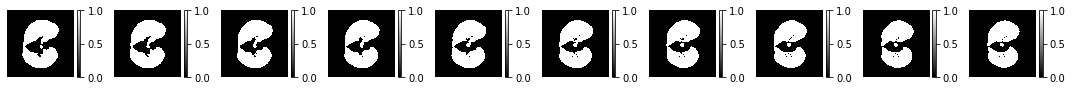

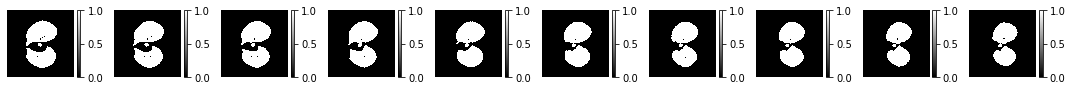

In [ ]:
"""image_path = "./dataset_modif/copd4/copd4_iBHCT.mhd"
I, header = load(image_path)
M = segm(I)
slices_2d = [M[:,:,f] for f in range(M.shape[2])]
print(len(slices_2d))
print(slices_2d[0].shape)
for i in range(10):
  ne.plot.slices(slices_2d[i*10:(i+1)*10], cmaps=['gray'], do_colorbars=True);"""

In [ ]:
data_path = os.listdir('newdata')
data=[]
segmentation=True
normalize=True
test_four=True#True for using 4 otherwise False for using all 8
extra=["copd0","copd5","copd6","copd7","copd8","copd9","copd10"]

for data_folder in data_path:
  if any(data_folder in s for s in extra) and data_folder != "copd1" and test_four:
    continue
  print("We are working with ",str(data_folder))
  inhale_imgPath = './newdata/{dir}/{dir}_iBHCT.nii.gz'.format(dir=data_folder)
  #exhale_imgPath = './dataset_modif/{dir}/{dir}_eBHCT.mhd'.format(dir=data_folder)
  #inhale_imgPath = './dataset_modif/{dir}/result.0.mhd'.format(dir=data_folder)
  #inhale_imgPath = './newdata/{dir}/result.1.nii.gz'.format(dir=data_folder)
  exhale_imgPath = './newdata/{dir}/{dir}_eBHCT.nii.gz'.format(dir=data_folder)
  
  inhale_data = nib.load(inhale_imgPath).get_fdata()
  exhale_data = nib.load(exhale_imgPath).get_fdata()
  
  print(inhale_data.shape)
  #print("voxel spacing: ",headeri.get_voxel_spacing())
  #print(exhale_data.shape)
  #print("voxel spacing: ",headere.get_voxel_spacing())

  if segmentation:
    seg_inhale_data = segm(inhale_data)
    seg_exhale_data = segm(exhale_data)
    inhale_data = np.multiply(inhale_data, seg_inhale_data)
    exhale_data = np.multiply(exhale_data, seg_exhale_data)

  if normalize:
    mean_i = np.mean(inhale_data[np.nonzero(inhale_data)])
    std_i = np.std(inhale_data[np.nonzero(inhale_data)])
    mean_e = np.mean(exhale_data[np.nonzero(exhale_data)])
    std_e = np.std(exhale_data[np.nonzero(exhale_data)])
  else:
    mean_i = mean_e = 0.0
    std_i = std_e = 1.0

  inhale_data = (inhale_data - mean_i) / std_i
  exhale_data = (exhale_data - mean_e) / std_e
  
  new_inhale = np.expand_dims(zoom(inhale_data, (0.5, 0.5, 128/inhale_data.shape[2])), axis=0)
  new_exhale = np.expand_dims(zoom(exhale_data, (0.5, 0.5, 128/exhale_data.shape[2])), axis=0)

  data.append(np.concatenate((new_inhale, new_exhale), axis=0))
  print("Done with ",str(data_folder))

np.save('data.npy',data)

We are working with  copd1
(512, 512, 121)
Done with  copd1
We are working with  copd2
(512, 512, 102)
Done with  copd2
We are working with  copd4
(512, 512, 126)
Done with  copd4
We are working with  copd3
(512, 512, 126)
Done with  copd3


#DATA LOADING

In [ ]:
data_train = np.load('data.npy')
print('train shape:', data_train.shape)#4 subjects, inhale then exhale, 256,256,128

train shape: (4, 2, 256, 256, 128)


#DATA GENERATOR

In [ ]:
def vxm_data_generator(x_data, batch_size=1):
    """
    generator that takes in data of size [N, X, Y, Z], and yields data for our vxm model
    inputs:  moving_image [bs, x, y, z, 1], fixed_image [bs, x, y, z, 1]
    outputs: moved_image  [bs, x, y, z, 1], zeros [bs, x, y, z, 2]
    """
    vol_shape = x_data.shape[2:] # extract data shape (256, 256, 128)
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation.
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])#(1, 256, 256, 128, 3)
    while True:
        # inputs of size [batch_size, x, y, z, 1]
        idx = np.random.randint(0, x_data.shape[0], size=batch_size)#0 to 3
        fixed_images = x_data[idx, 0, ..., np.newaxis]
        moving_images = x_data[idx, 1, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        outputs = [fixed_images, zero_phi]

        yield inputs, outputs

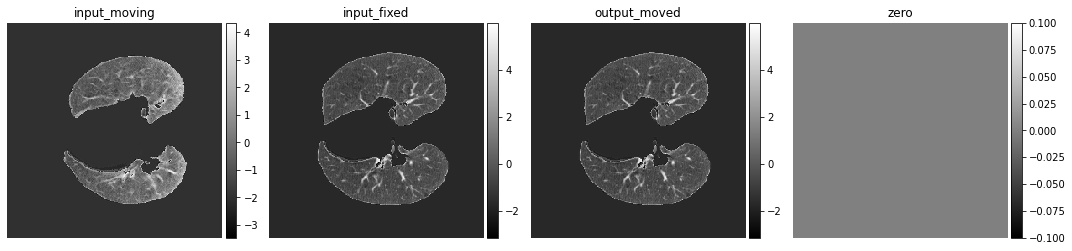

In [ ]:
# create the data generator
train_generator = vxm_data_generator(data_train,batch_size=1)

# visualize a sample
input_sample, output_sample = next(train_generator)
slices_2d = [f[0, :, :, 60, 0] for f in input_sample + output_sample]
titles = ['input_moving', 'input_fixed', 'output_moved', 'zero']
ne.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

#MODEL CREATION

In [ ]:
ndims = 3 #shows the correspondances between the images. Each pixel we want a vector telling us where to go

In [ ]:
#build model using VxmDense
inshape = data_train.shape[2:]
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 16, 8]  # decoder features
]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
#vxm_model.summary()

Instructions for updating:
Use fn_output_signature instead


In [ ]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 256, 256, 128, 1), (None, 256, 256, 128, 1)
output shape: (None, 256, 256, 128, 1), (None, 256, 256, 128, 3)


In [ ]:
# different loss for each output.
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

lambda_param = 0.0001#important hyper-parameter to balance both losses
loss_weights = [1, lambda_param]

In [ ]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [ ]:
mcp_save = ModelCheckpoint('NEWAFFINE_seg_mdl_wts.hdf5', save_best_only=True, monitor='loss', mode='min', verbose=1)
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')

nb_epochs = 40
steps_per_epoch = data_train.shape[0]

In [ ]:
model_detail = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2, callbacks=[mcp_save, reduce_lr_loss]);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/40

Epoch 00001: loss improved from inf to 0.49564, saving model to NEWAFFINE_seg_mdl_wts.hdf5
4/4 - 25s - loss: 0.4956 - transformer_loss: 0.4956 - flow_loss: 9.0266e-04 - lr: 0.0010 - 25s/epoch - 6s/step
Epoch 2/40

Epoch 00002: loss improved from 0.49564 to 0.36865, saving model to NEWAFFINE_seg_mdl_wts.hdf5
4/4 - 17s - loss: 0.3686 - transformer_loss: 0.3686 - flow_loss: 0.0124 - lr: 0.0010 - 17s/epoch - 4s/step
Epoch 3/40

Epoch 00003: loss did not improve from 0.36865
4/4 - 16s - loss: 0.3784 - transformer_loss: 0.3784 - flow_loss: 0.0112 - lr: 0.0010 - 16s/epoch - 4s/step
Epoch 4/40

Epoch 00004: loss improved from 0.36865 to 0.31097, saving model to NEWAFFINE_seg_mdl_wts.hdf5
4/4 - 16s - loss: 0.3110 - transformer_loss: 0.3110 - flow_loss: 0.0169 - lr: 0.0010 - 16s/epoch - 4s/step
Epoch 5/40

Epoch 00005: loss did not improve from 0.31097
4/4 - 16s - loss: 0.3839 - transformer_loss: 0.3839 - flow_loss: 0.0376 - lr: 0.0010 - 16s/epoch - 4s/step
Epoch 6/40

Epoch 00006: l

#Visualization of Graphs

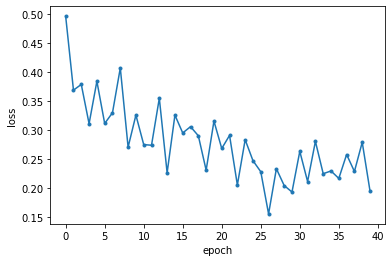

In [ ]:
def plot_history(model_detail):
    """
    Quick function to plot the history 
    """
    plt.figure()
    plt.plot(model_detail.epoch, model_detail.history['loss'], '.-')
    # plt.plot(hist.epoch, hist.history['disp_loss'], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(model_detail)

# Visualization of predictions

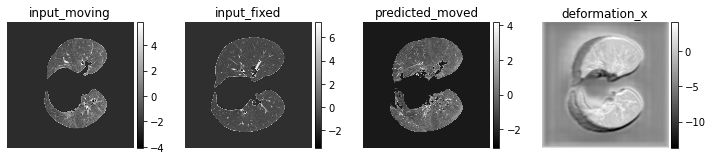

In [ ]:
vxm_model.load_weights('NEWAFFINE_seg_mdl_wts.hdf5')
val_generator = vxm_data_generator(data_train, batch_size = 1)
val_input, _ = next(val_generator)

val_pred = vxm_model.predict(val_input)

# visualize
slices_2d = [f[0, :, :, 60, 0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
ne.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True, width=10);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


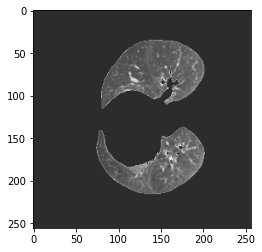

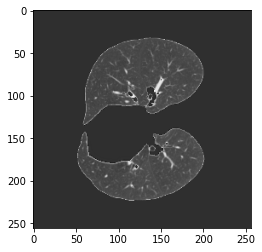

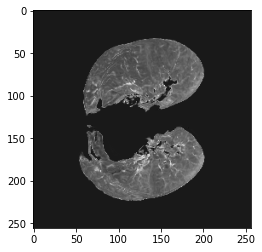

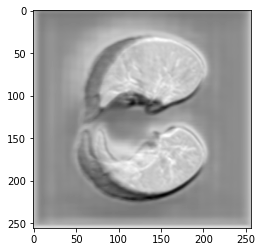

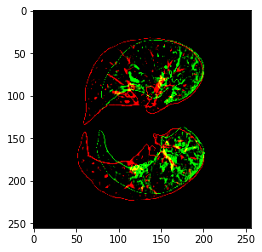

In [ ]:
plt.figure()
plt.imshow(slices_2d[0], cmap='gray')
plt.figure()
plt.imshow(slices_2d[1], cmap='gray')
plt.figure()
plt.imshow(slices_2d[2], cmap='gray')
plt.figure()
plt.imshow(slices_2d[3], cmap='gray')

zeros = np.expand_dims(np.zeros_like(slices_2d[2]), axis=2)
fixedImg = np.expand_dims(slices_2d[1], axis=2)
movedImg = np.expand_dims(slices_2d[0], axis=2)
imposedImg = np.concatenate((fixedImg, movedImg, zeros), axis= 2)
plt.figure()
plt.imshow(imposedImg, cmap='gray')
plt.savefig('data_zoom_normalized_4_unsegmented.png')

#Calculate TRE

In [ ]:
def calculateTRE(landmarks_fixed, landmarks_moving, voxel_dimensions):
    # Taking into account the voxel size
    landmarks_moving = voxel_dimensions * landmarks_moving
    landmarks_fixed  = voxel_dimensions * landmarks_fixed
    # Calculated the squared difference
    tre = np.sqrt(np.sum((landmarks_fixed - landmarks_moving) ** 2,axis =1))
    # Calculating the mean and std tre
    mean_tre = np.mean(tre)
    std_tre = np.std(tre)
    return mean_tre, std_tre

In [ ]:
def transform_landmarks(surface_points, trf):
    """surface_points is a N x D or a N x (D+1) Tensor
    trf is a *volshape x D Tensor"""
    surface_pts_D = surface_points.get_shape().as_list()[-1]
    trf_D = trf.get_shape().as_list()[-1]#3
    assert surface_pts_D in [trf_D, trf_D + 1]
    if surface_pts_D == trf_D + 1:
        li_surface_pts = K.expand_dims(surface_points[..., -1], -1)
        surface_points = surface_points[..., :-1]
    fn = lambda x: ne.utils.interpn(x[0], x[1])# just need to interpolate
    diff = tf.map_fn(fn, [trf, surface_points], dtype=tf.float32)# at each location determined by surface point, figure out the trf...
    ret = surface_points + diff
    if surface_pts_D == trf_D + 1:
        ret = tf.concat((ret, li_surface_pts), -1)
    return ret

In [ ]:
for case_number in range(1,5):
  path_to_data_dir = "newdata/"
  path_to_data_dir = "{}/copd{}/".format(path_to_data_dir,case_number)
  exhale = path_to_data_dir + 'copd' + str(case_number) + '_eBHCT.nii.gz'
  inhale = path_to_data_dir + 'result.1.nii.gz'
  landmarks_exhale = path_to_data_dir + 'copd' + str(case_number) + '_300_eBH_xyz_r1.txt'
  landmarks_inhale = path_to_data_dir + 'copd' + str(case_number) + '_300_eBH_xyz_r1_tr_AFFINE.txt'
  # Loading the inhale and exhale landmarks
  landmarks_moving = np.loadtxt(landmarks_exhale)
  landmarks_fixed = np.loadtxt(landmarks_inhale)
  ___ , header = load(inhale)
  voxel_spacing = header.get_voxel_spacing()
  print("voxel spacing: ",voxel_spacing)
  # Calculating the TRE before registration
  mean_tre , std_tre = calculateTRE(landmarks_fixed, landmarks_moving, voxel_spacing)
  print('mean and std of tre before doing registration is: ', mean_tre ," ", std_tre)
  
  if case_number == 1:
    sample_data = data_train[0:1,...]
    z_dim_i = 121
    z_dim_e = 119
    z_dim = max(z_dim_i,z_dim_e)
    
  elif case_number == 2:
    sample_data = data_train[1:2,...]
    z_dim_i = 102
    z_dim_e = 95
    z_dim = max(z_dim_i,z_dim_e)

  elif case_number == 3:
    sample_data = data_train[3:4,...]
    z_dim_i = 126
    z_dim_e = 116
    z_dim = max(z_dim_i,z_dim_e)

  elif case_number == 4:
    sample_data = data_train[2:3,...]
    z_dim_i = 126
    z_dim_e = 116
    z_dim = max(z_dim_i,z_dim_e)

  # THE OTHER SIDE
  val_generator = vxm_data_generator(sample_data, batch_size = 1)
  val_input, _ = next(val_generator)
  val_pred = vxm_model.predict(val_input)
  out_results = val_pred[1].squeeze()
  factor = z_dim / out_results.shape[2]
  new_out = zoom(out_results,(2, 2, factor,1),order=1)
  print(new_out.shape)

  data_tf = tf.convert_to_tensor(new_out, dtype=tf.float32)
  data_tf = K.expand_dims(data_tf, 0)
  landmarksF = tf.convert_to_tensor(landmarks_fixed, dtype=tf.float32)
  landmarksF = K.expand_dims(landmarksF, 0)

  transformed_points = transform_landmarks(landmarksF, data_tf)
  array = tf.squeeze(transformed_points)
  # Calculating the TRE before registration
  mean_tre , std_tre = calculateTRE(array, landmarks_moving, voxel_spacing)
  print('mean and std of tre after doing registration is: ', mean_tre ," ", std_tre)

voxel spacing:  (0.6200000047683716, 0.6200000047683716, 2.5)
mean and std of tre before doing registration is:  5.815576920265535   5.236365320412632
(512, 512, 121, 3)
mean and std of tre after doing registration is:  6.577118   4.7592616
voxel spacing:  (0.6399999856948853, 0.6399999856948853, 2.5)
mean and std of tre before doing registration is:  10.119693731105144   6.6251031155095035
(512, 512, 102, 3)
mean and std of tre after doing registration is:  11.116301   7.1080523
voxel spacing:  (0.6499999761581421, 0.6499999761581421, 2.5)
mean and std of tre before doing registration is:  3.427050060109191   3.262255471916255
(512, 512, 126, 3)
mean and std of tre after doing registration is:  5.860023   5.0963774
voxel spacing:  (0.5899999737739563, 0.5899999737739563, 2.5)
mean and std of tre before doing registration is:  8.71098388206124   5.3086382073967995
(512, 512, 126, 3)
mean and std of tre after doing registration is:  8.431053   4.8007236
